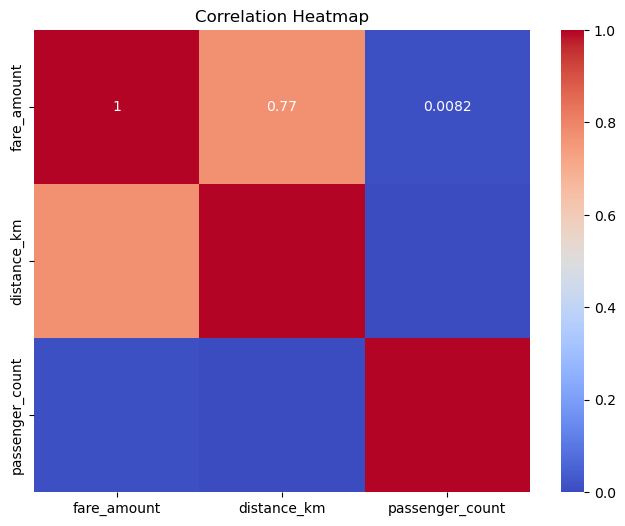

===== Linear Regression =====
R²: 0.7392098208335618
RMSE: 4.666558072849514
MAE: 2.7414045098625923



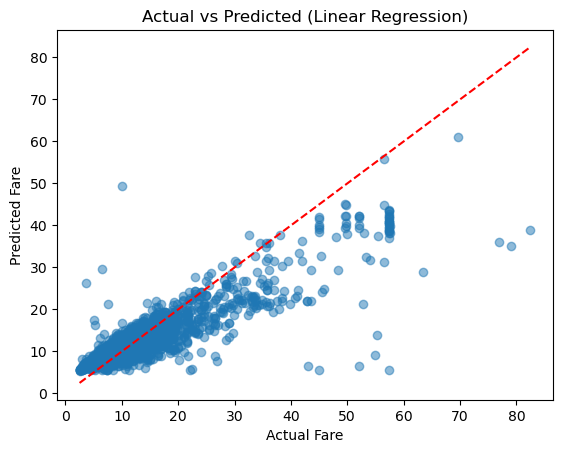

===== Ridge Regression =====
R²: 0.7392083841331353
RMSE: 4.666570926931599
MAE: 2.741414809174154



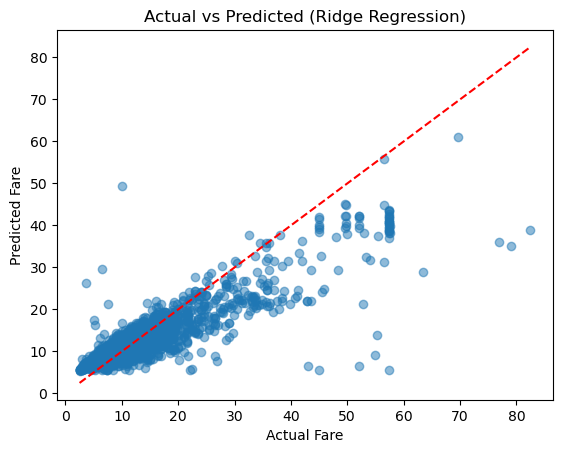

===== Lasso Regression =====
R²: 0.738132007003377
RMSE: 4.676191286021018
MAE: 2.7501739270219625



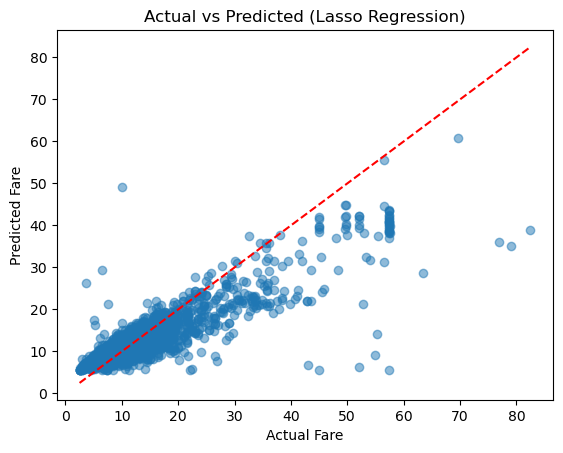

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset (local file)
df = pd.read_csv("cab.csv")

# Convert data types
df['fare_amount'] = pd.to_numeric(df['fare_amount'], errors='coerce')
df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce')

# Drop rows with missing values
df.dropna(subset=['fare_amount', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                  'dropoff_longitude', 'dropoff_latitude'], inplace=True)

# Convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Vectorized Haversine formula for distance calculation
def haversine_vectorized(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # km

# Apply haversine distance
df['distance_km'] = haversine_vectorized(
    df['pickup_longitude'], df['pickup_latitude'],
    df['dropoff_longitude'], df['dropoff_latitude']
)

# Remove unrealistic fares and distances
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200)]
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 100)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['fare_amount', 'distance_km', 'passenger_count']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Features and target
X = df[['distance_km', 'passenger_count']]
y = df['fare_amount']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"===== {name} =====")
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print()

    # Plot Actual vs Predicted
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Fare")
    plt.ylabel("Predicted Fare")
    plt.title(f"Actual vs Predicted ({name})")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()